In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR  # Import SVM for regression

In [2]:
# Đọc dữ liệu
train_df = pd.read_csv('../Dataset/712/train.csv')
valid_df = pd.read_csv('../Dataset/712/valid.csv')
test_df = pd.read_csv('../Dataset/712/test.csv')

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (31362, 17)
Valid: (4480, 17)
Test: (8962, 17)


In [3]:
# Hàm tiền xử lý
def preprocess(df, encoders=None, scaler=None, is_train=True):
    df = df.copy()

    # Tính Revenue
    df['Revenue'] = df['Quantity'] * df['UnitPrice'] * (1 - df['Discount'])

    # Các cột
    categorical_cols = ['Country', 'Category', 'SalesChannel', 'PaymentMethod']
    numerical_cols = ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost']
    target_col = 'Revenue'
    
    # Encode categorical
    if is_train:
        encoders = {col: LabelEncoder().fit(df[col].astype(str)) for col in categorical_cols}
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col].astype(str))
    
    # Scale numerical
    if is_train:
        scaler = StandardScaler().fit(df[numerical_cols])
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    
    # Features and Target
    X = df[categorical_cols + numerical_cols]
    y = df[target_col] if target_col in df.columns else None
    
    return X, y, encoders, scaler

In [4]:
# 3. Chuẩn hóa dữ liệu 
X_train, y_train, encoders, scaler = preprocess(train_df, is_train=True)
X_valid, y_valid, _, _ = preprocess(valid_df, encoders, scaler, is_train=False)
X_test, _, _, _ = preprocess(test_df, encoders, scaler, is_train=False)


In [5]:
# Khởi tạo dataset cho PyTorch
class SalesDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

train_data = SalesDataset(X_train, y_train)
valid_data = SalesDataset(X_valid, y_valid)
test_data = SalesDataset(X_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

# SVM Regressor
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Huấn luyện mô hình SVM
svm_model.fit(X_train, y_train)


SVR()

In [6]:
# Dự đoán trên tập validation
val_preds = svm_model.predict(X_valid)
val_mae = mean_absolute_error(y_valid, val_preds)
val_mse = mean_squared_error(y_valid, val_preds)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_valid, val_preds)

print(f"Val MAE: {val_mae:.2f}, Val MSE: {val_mse:.2f}, Val RMSE: {val_rmse:.2f}, Val R²: {val_r2:.2f}")

# Dự đoán trên tập test
test_preds = svm_model.predict(X_test)

# Tính lại cột 'Revenue' cho test_df 
test_df['Revenue'] = test_df['Quantity'] * test_df['UnitPrice'] * (1 - test_df['Discount'])
test_true = test_df['Revenue'].values

# Đánh giá mô hình trên tập test
test_mae = mean_absolute_error(test_true, test_preds)
test_mse = mean_squared_error(test_true, test_preds)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_true, test_preds)

print(f"Test MAE: {test_mae:.2f}, Test MSE: {test_mse:.2f}, Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")


Val MAE: 342.96, Val MSE: 283923.92, Val RMSE: 532.85, Val R²: 0.62
Test MAE: 336.84, Test MSE: 273084.18, Test RMSE: 522.57, Test R²: 0.62


Doanh thu ngày 2024-07-14: Thực tế = 5555.79, Dự đoán = 6451.58
Doanh thu ngày 2024-07-15: Thực tế = 17284.46, Dự đoán = 15083.44
Doanh thu ngày 2024-07-16: Thực tế = 17465.11, Dự đoán = 14602.83
Doanh thu ngày 2024-07-17: Thực tế = 18793.60, Dự đoán = 14929.62
Doanh thu ngày 2024-07-18: Thực tế = 17826.91, Dự đoán = 14985.29
Doanh thu ngày 2024-07-19: Thực tế = 21833.84, Dự đoán = 17091.88
Doanh thu ngày 2024-07-20: Thực tế = 22494.09, Dự đoán = 17874.13
Doanh thu ngày 2024-07-21: Thực tế = 26006.19, Dự đoán = 20907.80
Doanh thu ngày 2024-07-22: Thực tế = 16874.65, Dự đoán = 15223.89
Doanh thu ngày 2024-07-23: Thực tế = 33938.36, Dự đoán = 22531.21
Doanh thu ngày 2024-07-24: Thực tế = 23208.85, Dự đoán = 20197.83
Doanh thu ngày 2024-07-25: Thực tế = 21291.44, Dự đoán = 17072.51
Doanh thu ngày 2024-07-26: Thực tế = 18288.27, Dự đoán = 15449.96
Doanh thu ngày 2024-07-27: Thực tế = 21034.51, Dự đoán = 17491.55
Doanh thu ngày 2024-07-28: Thực tế = 26938.66, Dự đoán = 19049.71
Doanh thu ng

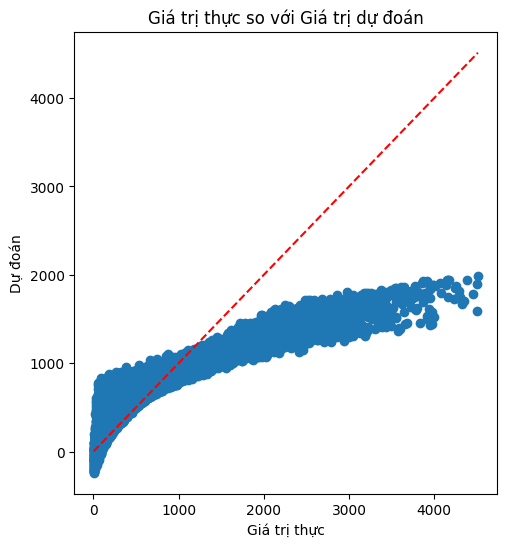

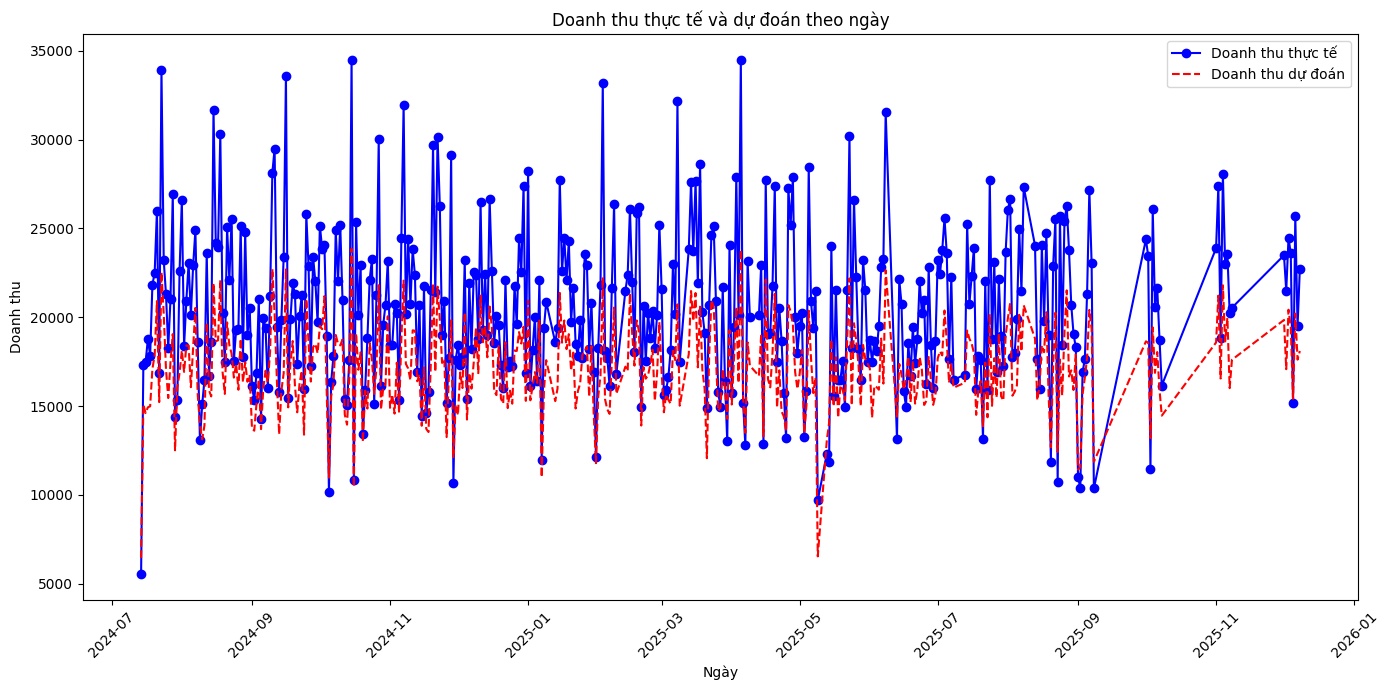

In [7]:
# Vẽ đồ thị kết quả dự đoán so với giá trị thực tế
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(test_true, test_preds)
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], color='red', linestyle='--')
plt.xlabel('Giá trị thực')
plt.ylabel('Dự đoán')
plt.title('Giá trị thực so với Giá trị dự đoán')

# Chắc chắn rằng cột InvoiceDate có kiểu dữ liệu datetime
if 'InvoiceDate' in test_df.columns:
    test_df['InvoiceDate'] = pd.to_datetime(test_df['InvoiceDate'])
    
    # Dự đoán doanh thu từ mô hình
    test_df['PredictedRevenue'] = test_preds
    
    # Nhóm dữ liệu theo ngày
    daily_sales = test_df.groupby(test_df['InvoiceDate'].dt.date).agg({'Revenue': 'sum', 'PredictedRevenue': 'sum'}).reset_index()

    # In ra doanh thu thực tế và dự đoán theo ngày
    for idx, row in daily_sales.iterrows():
        print(f"Doanh thu ngày {row['InvoiceDate']}: Thực tế = {row['Revenue']:.2f}, Dự đoán = {row['PredictedRevenue']:.2f}")

    # Vẽ đồ thị doanh thu thực tế và dự đoán theo ngày
    plt.figure(figsize=(14, 7))
    plt.plot(daily_sales['InvoiceDate'], daily_sales['Revenue'], label='Doanh thu thực tế', color='blue', marker='o')
    plt.plot(daily_sales['InvoiceDate'], daily_sales['PredictedRevenue'], label='Doanh thu dự đoán', color='red', linestyle='--')
    plt.xlabel('Ngày')
    plt.ylabel('Doanh thu')
    plt.title('Doanh thu thực tế và dự đoán theo ngày')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()